## Three Stock Monte

This exercise tests your ability to retrieve stock price data using the Alpaca API and simulate multiple portfolio compositions using Monte Carlo Simulation.

### Import Dependencies

In [1]:
# Import libraries and dependencies
import os
import pandas as pd
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

### Get Past ~4 Year's Worth of Stock Price Data via Alpaca API Call

In [4]:
# Set timeframe to "1Day"
timeframe = "1Day"

# Set start and end datetimes between now and 4 years ago.
start_date = pd.Timestamp("2017-05-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-05-01", tz="America/New_York").isoformat()

# Set the ticker information
tickers = ["T","NKE","XOM"]

# Get 4 year's worth of historical price data
# HINT: Set "limit" to at least 10000 so all ticker rows are captured from get_bars()
df_ticker = api.get_bars(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df

# Display sample data
df_ticker.head()

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2017-05-01 04:00:00+00:00,55.43,55.45,54.98,54.99,4881442,30491,55.201737,NKE
2017-05-02 04:00:00+00:00,55.12,55.16,54.79,55.07,7363885,41589,54.967165,NKE
2017-05-03 04:00:00+00:00,55.17,55.30,54.40,54.53,9486619,48477,54.622933,NKE
2017-05-04 04:00:00+00:00,54.68,54.83,54.20,54.47,6830628,39260,54.501544,NKE
2017-05-05 04:00:00+00:00,54.41,54.50,53.56,53.95,13379949,57959,53.889567,NKE


> Note: We're going to simulate five years of growth below, and so we might want to pull at least five years of data in order to do that. But we pulled four because of Alpaca's rate limits--we can only pull 1,000 rows per ticker at a time (approximately four years of data, with 252 tradable days per year). If we pull data with repeated calls in a `for` loop, however, we can get quite a few more years than what we've got above.  

In [5]:
# Reorganize the DataFrame
# Separate ticker data
T = df_ticker[df_ticker["symbol"]=="T"].drop("symbol", axis=1)
NKE = df_ticker[df_ticker["symbol"]=="NKE"].drop("symbol", axis=1)
XOM = df_ticker[df_ticker["symbol"]=="XOM"].drop("symbol", axis=1)

# Concatenate the ticker DataFrames
df_ticker = pd.concat([T, NKE, XOM], axis=1, keys=["T","NKE","XOM"])

# Display sample data
df_ticker.head()

T                                              
                            open   high    low  close    volume trade_count   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.68  39.70  39.06  39.10  24750447       95238  \
2017-05-02 04:00:00+00:00  39.14  39.22  38.88  38.95  24852467       86237   
2017-05-03 04:00:00+00:00  38.94  38.98  38.15  38.40  33743554      113920   
2017-05-04 04:00:00+00:00  38.41  38.41  37.63  38.01  31450002      118191   
2017-05-05 04:00:00+00:00  38.08  38.71  38.03  38.56  21829853       82070   

                                        NKE                ...             
                                vwap   open   high    low  ...    volume   
timestamp                                                  ...             
2017-05-01 04:00:00+00:00  39.278779  55.43  55.45  54.98  ...   4881442  \
2017-05-02 04:00:00+00:00  38.996448  55.12  55.16  54.79  ...   7363885   
2017-05-03 04:00:00+00:00  38.423685  55.17  55.30  54.40  ...   9486619   
2017-05-04 04:00:00+00:00  37.965109  54.68  54.83  54.20  ...   6830628   
2017-05-05 04:00:00+00:00  38.424403  54.41  54.50  53.56  ...  13379949   

                                                    XOM                   
                          trade_count       vwap   open     high    low   
timestamp                                                                 
2017-05-01 04:00:00+00:00       30491  55.201737  81.51  82.2100  81.48  \
2017-05-02 04:00:00+00:00       41589  54.967165  82.14  82.5900  81.90   
2017-05-03 04:00:00+00:00       48477  54.622933  81.97  83.0699  81.91   
2017-05-04 04:00:00+00:00       39260  54.501544  82.29  82.3600  81.40   
2017-05-05 04:00:00+00:00       57959  53.889567  81.63  82.2350  81.61   

                                                                   
                           close    volume trade_count       vwap  
timestamp                                                          
2017-05-01 04:00:00+00:00  82.06   8664579       49226  81.941004  
2017-05-02 04:00:00+00:00  82.05   9102893       54234  82.197909  
2017-05-03 04:00:00+00:00  82.70  10289447       57309  82.625679  
2017-05-04 04:00:00+00:00  81.64  16165093       86289  81.729800  
2017-05-05 04:00:00+00:00  82.02  10212004       59397  81.932657  

[5 rows x 21 columns]

### Simulate five year portfolio growth with evenly-distributed stock investments

In [6]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns
MC_even_dist = MCSimulation(
    portfolio_data = df_ticker,
    weights = [.33,.33,.33],
    num_simulation = 1000,
    num_trading_days = 252*5
)

# Print the simulation input data
MC_even_dist.portfolio_data.head()

T                                              
                            open   high    low  close    volume trade_count   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.68  39.70  39.06  39.10  24750447       95238  \
2017-05-02 04:00:00+00:00  39.14  39.22  38.88  38.95  24852467       86237   
2017-05-03 04:00:00+00:00  38.94  38.98  38.15  38.40  33743554      113920   
2017-05-04 04:00:00+00:00  38.41  38.41  37.63  38.01  31450002      118191   
2017-05-05 04:00:00+00:00  38.08  38.71  38.03  38.56  21829853       82070   

                                                     NKE         ...   
                                vwap daily_return   open   high  ...   
timestamp                                                        ...   
2017-05-01 04:00:00+00:00  39.278779          NaN  55.43  55.45  ...  \
2017-05-02 04:00:00+00:00  38.996448    -0.003836  55.12  55.16  ...   
2017-05-03 04:00:00+00:00  38.423685    -0.014121  55.17  55.30  ...   
2017-05-04 04:00:00+00:00  37.965109    -0.010156  54.68  54.83  ...   
2017-05-05 04:00:00+00:00  38.424403     0.014470  54.41  54.50  ...   

                                                     XOM                   
                                vwap daily_return   open     high    low   
timestamp                                                                  
2017-05-01 04:00:00+00:00  55.201737          NaN  81.51  82.2100  81.48  \
2017-05-02 04:00:00+00:00  54.967165     0.001455  82.14  82.5900  81.90   
2017-05-03 04:00:00+00:00  54.622933    -0.009806  81.97  83.0699  81.91   
2017-05-04 04:00:00+00:00  54.501544    -0.001100  82.29  82.3600  81.40   
2017-05-05 04:00:00+00:00  53.889567    -0.009547  81.63  82.2350  81.61   

                                                                                
                           close    volume trade_count       vwap daily_return  
timestamp                                                                       
2017-05-01 04:00:00+00:00  82.06   8664579       49226  81.941004          NaN  
2017-05-02 04:00:00+00:00  82.05   9102893       54234  82.197909    -0.000122  
2017-05-03 04:00:00+00:00  82.70  10289447       57309  82.625679     0.007922  
2017-05-04 04:00:00+00:00  81.64  16165093       86289  81.729800    -0.012817  
2017-05-05 04:00:00+00:00  82.02  10212004       59397  81.932657     0.004655  

[5 rows x 24 columns]

In [7]:
# Run a Monte Carlo simulation to forecast five years cumulative returns
MC_even_dist.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 160.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 170.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 180.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 190.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 200.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 210.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 220.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 230.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 240.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 250.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 260.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 270.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 280.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 290.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 300.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 310.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 320.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 330.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 340.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 350.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 360.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 370.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 380.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 390.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 400.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 410.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 420.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 430.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 440.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 450.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 460.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 470.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 480.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 490.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 500.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 510.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 520.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 530.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 540.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 550.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 560.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 570.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 580.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 590.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 600.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 610.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 620.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 630.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 640.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 650.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 660.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 670.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 680.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 690.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 700.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 710.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 720.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 730.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 740.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 750.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 760.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 770.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 780.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 790.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 800.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 810.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 820.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 830.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 840.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 850.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 860.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 870.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 880.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 890.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 900.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 910.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 920.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 930.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 940.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 950.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 960.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 970.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 980.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

Running Monte Carlo simulation number 990.


C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\Ravena\Desktop\Completed Tasks\Completed Tasks\05-APIs\Instructions\Sta

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.991027,0.979929,1.003676,0.988247,1.016356,0.997082,0.970038,0.996785,1.005914,0.991526,...,1.005066,0.986440,1.019719,1.003056,1.011201,0.999055,1.005043,0.989862,0.997730,1.001676
2,0.988042,0.963096,1.019985,0.968150,1.022526,0.984960,0.975850,0.983895,1.005144,0.992370,...,1.002069,1.002520,1.026093,1.025321,1.011265,1.014615,1.008138,0.990555,1.011419,0.996026
3,0.979267,0.970788,1.014413,0.977899,1.030882,0.983061,0.970348,0.978405,1.018053,0.993848,...,1.009544,1.003721,1.032660,1.020824,0.989773,1.009064,1.000891,0.993693,1.021288,1.006005
4,0.973978,0.952977,1.030747,0.967244,1.030853,0.973885,0.970538,0.978184,1.032710,1.005146,...,1.006057,1.005781,1.045691,1.015632,0.982658,1.015613,1.000779,1.009510,1.016142,0.997634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.563998,1.089711,1.021312,1.575831,1.575450,1.037737,2.320371,1.621416,2.157855,1.227254,...,0.954521,1.841761,1.151679,1.649400,1.295197,1.713457,1.068252,1.133797,0.784105,0.993699
1257,1.563170,1.075140,1.037561,1.601597,1.566860,1.026324,2.326597,1.661595,2.154751,1.238759,...,0.978449,1.812090,1.146050,1.640830,1.269944,1.693864,1.071002,1.122576,0.771745,0.989471
1258,1.572832,1.072246,1.050242,1.611762,1.539668,1.005540,2.303174,1.679126,2.124339,1.232799,...,0.972240,1.822856,1.154400,1.663596,1.282254,1.701167,1.078949,1.118582,0.773489,0.980723
1259,1.553807,1.066003,1.031520,1.613710,1.553442,1.007862,2.348242,1.681076,2.135331,1.241498,...,0.953471,1.824694,1.127710,1.650100,1.272678,1.699593,1.097801,1.139532,0.785966,0.972362


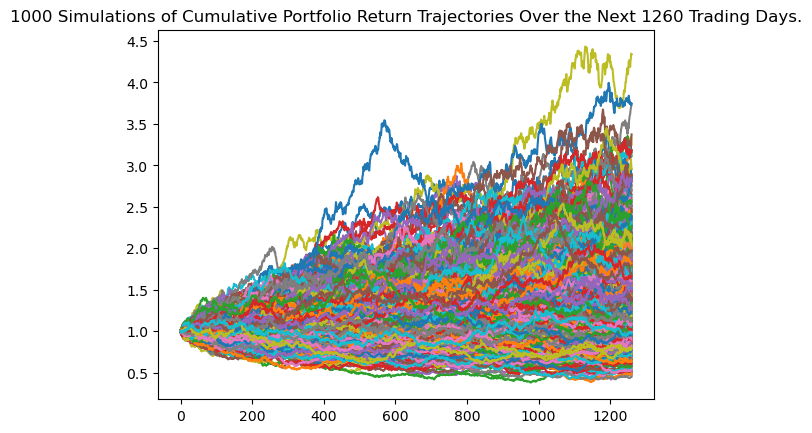

In [8]:
# Plot simulation outcomes
line_plot = MC_even_dist.plot_simulation()

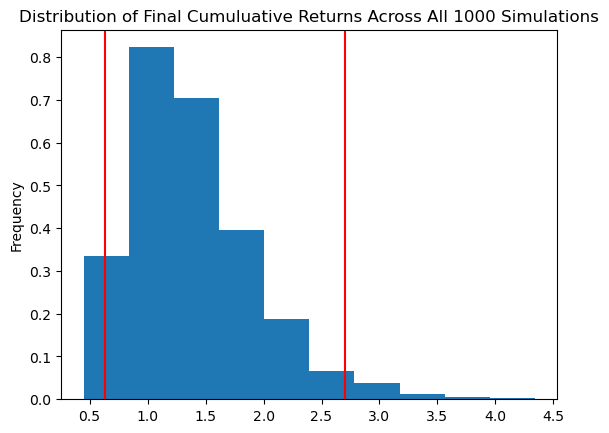

In [9]:
# Plot probability distribution and confidence intervals
dist_plot = MC_even_dist.plot_distribution()

In [10]:
# Fetch summary statistics from the Monte Carlo simulation results
even_tbl = MC_even_dist.summarize_cumulative_return()

# Print summary statistics
print(even_tbl)

AttributeError: 'Series' object has no attribute 'append'

In [ ]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments in stocks
even_ci_lower = round(even_tbl[8]*15000,2)
even_ci_upper = round(even_tbl[9]*15000,2)

# Print results
print(f"There is a 95% chance that an initial investment of $15,000 in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${even_ci_lower} and ${even_ci_upper}.")

### Simulate five year portfolio growth with 60% AT&T stock

In [ ]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns with 60% AT&T stock
MC_att = MCSimulation(
    portfolio_data = df_ticker,
    weights = [.20,.60,.20],
    num_simulation = 1000,
    num_trading_days = 252*5)

# Print the simulation input data
MC_att.portfolio_data.head()

In [ ]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% AT&T stock
MC_att.calc_cumulative_return()

In [ ]:
# Plot simulation outcomes
att_line_plot = MC_att.plot_simulation()

In [ ]:
# Plot probability distribution and confidence intervals
att_dist_plot = MC_att.plot_distribution()

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
att_tbl = MC_att.summarize_cumulative_return()

# Print summary statistics
print(att_tbl)

In [ ]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
att_ci_lower = round(att_tbl[8]*15000,2)
att_ci_upper = round(att_tbl[9]*15000,2)

# Print results
print(f"There is a 95% chance that an initial investment of $15,000 in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${att_ci_lower} and ${att_ci_upper}.")

### Simulate five year portfolio growth with 60% Nike stock

In [ ]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns with 60% Nike stock
MC_nike = MCSimulation(
    portfolio_data = df_ticker,
    weights = [.60,.20,.20],
    num_simulation = 1000,
    num_trading_days = 252*5
)

# Printing the simulation input data
MC_nike.portfolio_data.head()

In [ ]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% Nike stock
MC_nike.calc_cumulative_return()

In [ ]:
# Plot simulation outcomes
nike_line_plot = MC_nike.plot_simulation()

In [ ]:
# Plot probability distribution and confidence intervals
nike_dist_plot = MC_nike.plot_distribution()

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
nike_tbl = MC_nike.summarize_cumulative_return()

# Print summary statistics
print(nike_tbl)

In [ ]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
nike_ci_lower = round(nike_tbl[8]*15000,2)
nike_ci_upper = round(nike_tbl[9]*15000,2)

# Print results
print(f"There is a 95% chance that an initial investment of $15,000 in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${nike_ci_lower} and ${nike_ci_upper}.")

### Simulate five year portfolio growth with 60% Exxon stock

In [ ]:
# Configuring a Monte Carlo simulation to forecast five years cumulative returns
MC_exxon = MCSimulation(
    portfolio_data = df_ticker,
    weights = [.20,.20,.60],
    num_simulation = 1000,
    num_trading_days = 252*5)

# Printing the simulation input data
MC_exxon.portfolio_data

In [ ]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% Exxon stock
MC_exxon.calc_cumulative_return()

In [ ]:
# Plot simulation outcomes
exxon_line_plot = MC_exxon.plot_simulation()

In [ ]:
# Plot probability distribution and confidence intervals
exxon_dist_plot = MC_exxon.plot_distribution()

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
exxon_tbl = MC_exxon.summarize_cumulative_return()

# Print summary statistics
print(exxon_tbl)

In [ ]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
exxon_ci_lower = round(exxon_tbl[8]*15000,2)
exxon_ci_upper = round(exxon_tbl[9]*15000,2)

# Print results
print(f"There is a 95% chance that an initial investment of $15,000 in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${exxon_ci_lower} and ${exxon_ci_upper}.")

### Summarize findings across all 4 simulations

In [ ]:
# Even weighted stocks
print("Even weighted stocks")
print(f"There is a 95% chance that an initial investment of $15,000 in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${even_ci_lower} and ${even_ci_upper}.")
print("*"*50)

# 60% for AT&T
print("60% for AT&T")
print(f"There is a 95% chance that an initial investment of $15,000 in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${att_ci_lower} and ${att_ci_upper}.")
print("*"*50)

# 60% for Nike
print("60% for Nike")
print(f"There is a 95% chance that an initial investment of $15,000 in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${nike_ci_lower} and ${nike_ci_upper}.")
print("*"*50)

# 60% for Exxon
print("60% for Exxon")
print(f"There is a 95% chance that an initial investment of $15,000 in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${exxon_ci_lower} and ${exxon_ci_upper}.")
print("*"*50)

Looking across all four simulations, the portfolio breakdown with the greatest chance of success looks to be the portfolio with a majority of Nike stock. Although all four portfolios have a chance to lose money, the Nike portfolio is roughly the same level of risk with far more upside potential.